<a href="https://colab.research.google.com/github/Mohammed-Jemal/Imaga_classification_with_Resnet50/blob/main/Call256_Resnet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D,Flatten,RandomRotation
from tensorflow.keras.layers import RandomFlip,RandomZoom, GlobalAveragePooling2D,Dropout, BatchNormalization
from tensorflow.keras.applications import resnet50, vgg19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.optimizers import Adam

In [45]:
image_ds_path= '/content/drive/MyDrive/ CSC451_SP24_datasets/ Cal256_26'

In [46]:
#preprocess and split the image datasets
train_image= image_dataset_from_directory(
    image_ds_path,
    labels='inferred',
    batch_size=32,

    validation_split=0.30,
    subset='training',
    shuffle=True,
    image_size= (224,224),
    color_mode='rgb',
    seed=123

)
val_image= image_dataset_from_directory(
    image_ds_path,
    labels='inferred',
    batch_size=32,
    validation_split=0.30,
    subset='validation',
    image_size=(224,224),
    color_mode='rgb',
    shuffle=True,
    seed=123
)



Found 1086 files belonging to 26 classes.
Using 761 files for training.
Found 1086 files belonging to 26 classes.
Using 325 files for validation.


In [47]:
#Data normalization with preprocess_input function
def image_preprocess(image,label):
  image= preprocess_input(image)
  return image,label
train_image= train_image.map(image_preprocess)
val_image = val_image.map(image_preprocess)

##**Loading the pretrained resnet50 model**

In [48]:
base_model= resnet50.ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3))

In [49]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

In [54]:
#unfrezing the last six layers from base model
base_model.trainable=True
for layer in base_model.layers[:-6]:
    layer.trainable = False

model= Sequential([
    data_augmentation,
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(48, activation='relu', kernel_regularizer=L2(0.001)),

    #Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(48, activation='relu'),
    Dropout(0.3),
    Dense(26, activation='softmax', kernel_regularizer=L2(0.001))
    ])

In [55]:
#optimization
optm = Adam(learning_rate=1e-4)
model.compile(optimizer=optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:

#Train the model
earlystopping= EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=3,
    restore_best_weights=True

)

modelchekpoint= ModelCheckpoint(
    'Cal256_image_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss',factor=0.5, patience=3, verbose=1)

history= model.fit(train_image,
                   epochs=100,
                   validation_data=val_image,
                   callbacks=[earlystopping, modelchekpoint, reduce_lr])


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 389ms/step - accuracy: 0.0552 - loss: 3.3385 - val_accuracy: 0.1385 - val_loss: 3.1894 - learning_rate: 1.0000e-04
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.0752 - loss: 3.2410 - val_accuracy: 0.1815 - val_loss: 3.0534 - learning_rate: 1.0000e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.1035 - loss: 3.1737 - val_accuracy: 0.2308 - val_loss: 2.9558 - learning_rate: 1.0000e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.1047 - loss: 3.1332 - val_accuracy: 0.2554 - val_loss: 2.8631 - learning_rate: 1.0000e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.1036 - loss: 3.0913 - val_accuracy: 0.2615 - val_loss: 2.7820 - learning_rate: 1.0000e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.1453 - loss: 3.0061 - val_accuracy: 0.2985 - val_loss: 2.7686 - learning_rate: 1.0000e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - 

In [53]:
#/content/Cal256_image_best_model.keras

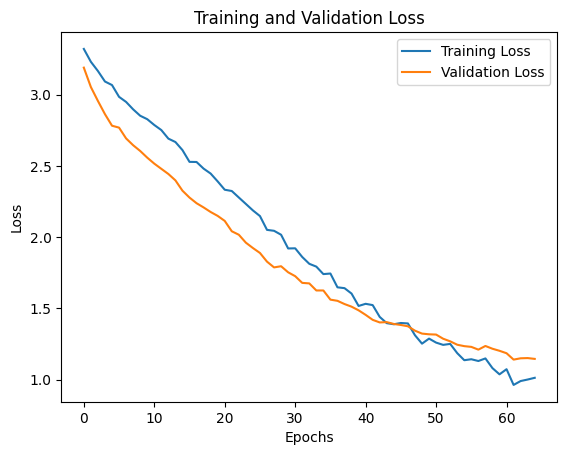

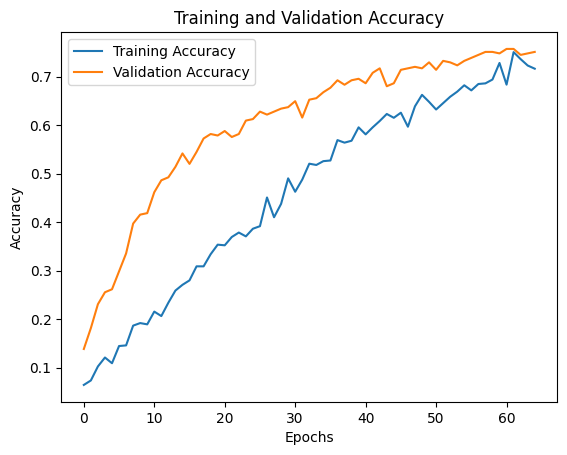

In [57]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


## Test data set

In [58]:

test_image= image_dataset_from_directory(
    '/content/drive/MyDrive/ CSC451_SP24_datasets/ Cal256_test',
    image_size=(224,224),
    labels = 'inferred',

    batch_size= 4,
    shuffle=False

)

Found 105 files belonging to 26 classes.


In [59]:
test_loss, test_accuracy = model.evaluate(test_image)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 763ms/step - accuracy: 0.4777 - loss: 2.1021
Test Loss: 1.7946
Test Accuracy: 0.5810


In [60]:
#predict the image
predictions = model.predict(test_image)
predicted_labels = tf.argmax(predictions, axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


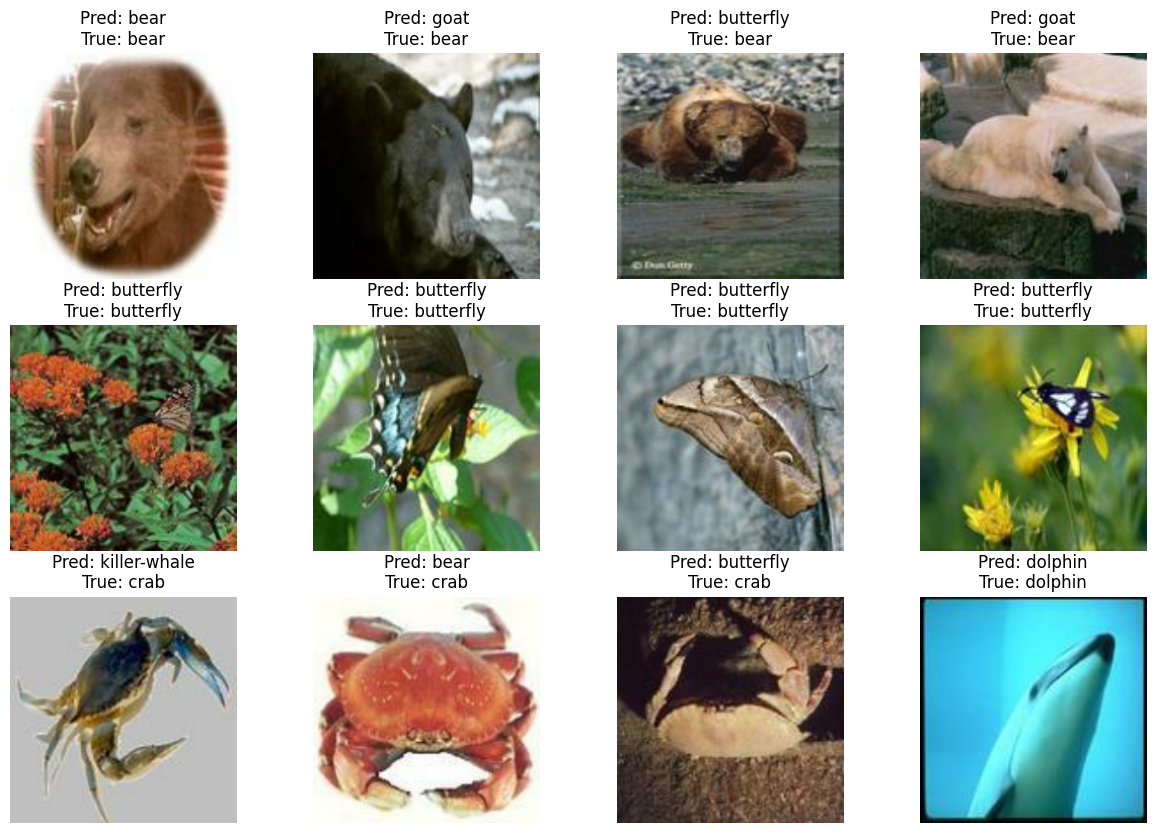

In [65]:
# For larger visualization
batch_size = 4  # since there is only 4 image per class
num_batches_to_viz = 3  # 3 batches × 4 images = 12 total

plt.figure(figsize=(15, 10))
plot_index = 1

for images, labels in test_image.take(num_batches_to_viz):
    predictions = model.predict(images)
    for i in range(images.shape[0]):
        plt.subplot(num_batches_to_viz, batch_size, plot_index)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[np.argmax(predictions[i])]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")
        plot_index += 1